<a href="https://www.dialogasia.com/"><img src = "https://www.eog-asia.com/wp-content/uploads/2018/02/Dialog-Group.jpg" width = 200> 

<h1 align=center><font size = 5>Core Analysis Petang Kenarong</font></h1>

<h1 align=center><font size = 4> Munish Kumar </font></h1>
<h1 align=center><font size = 4> P5936_Pertang-Kenarong & Bedong-Noring_Evaluation </font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install sympy --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

# Sklearn Liraries
from sklearn import preprocessing

# For Latex style text
from sympy import S, symbols, printing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\mkumar\Documents\GitHub\Core_Analysis_PK_Dialog'
filename_suffix = 'csv'

# Font, marker size and axis rotation
edgecolors = 'black'
markersize = 16
alpha = 0.5
size = 18
rotation = 0

###### Series of Functions

In [3]:
# Function to look at first 5 and last 5 elements in a dataframe
def ends(df, x=5):
    return df.head(x).append(df.tail(x))
setattr(pd.DataFrame,'ends',ends)

In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

In [5]:
# Function to search for a text string
def search_words(text):
    result = re.findall(r'\b[^\d\W]+\b', text)
    return " ".join(result)

In [6]:
# Function to plot grain density
def plot_grain_density(mod_df, title, bins, xmin, xmax, savefn):
    sns.set()
    sns.set_style("whitegrid")     
    sns.set_style("ticks", 
                  {"xtick.major.size":size,
                  "ytick.major.size":size}
                 )
    sns.axes_style("whitegrid")
    kwargs = {'cumulative': True}

    ax = sns.distplot(mod_df, 
                      bins = bins, 
                      kde=False, 
                      norm_hist=False, 
                      color = 'r',
                      #bw_adjust=.25,
                      #hist_kws=kwargs, 
                      #kde_kws=kwargs
                     )
    ax.set(ylabel='Frequency', 
           #xlabel='common ylabel',
           xlim = (xmin, xmax),
          )

    ax.legend(labels=['Histogram', 'Frequency'])
    plt.title(title)
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [7]:
# Plotting the effect of NOBP
def plot_NOBP(mod_df, df_sub, grouped, color, savefn):
    # Plot per group
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(121)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["NOB (psi)"],
            group["Porosity (%)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6))
    ax.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax.set_ylabel('Porosity (%)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.ylim(0,20) 
    plt.grid(True)
    
    ax1 = fig.add_subplot(122)

    for i, (name, group) in enumerate(grouped):
        sc1 = ax1.scatter(
            group["NOB (psi)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends (one for gender, other for size)
    ax1.add_artist(ax1.legend(title='Well Name'))
    ax1.legend(*sc1.legend_elements("colors", num=6))
    ax1.set_xlabel('Net Overburden Pressure (psi)', fontsize=size)
    ax1.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    #plt.ylim(0,20)

    plt.tight_layout()
    plt.grid(True)

    plt.savefig(savefn, transparent=True)
    return

In [8]:
def plot_PP(mod_df, df_sub, grouped, color, title, savefn, xint1, yint1, xint2, yint2):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111)

    for i, (name, group) in enumerate(grouped):
        sc = ax.scatter(
            group["Porosity (%)"],
            group["K_klin (mD)"],
            s = markersize**2,
            alpha=0.5,
            label=name,
            edgecolors = edgecolors,
        )  

    # Add legends
    ax.add_artist(ax.legend(title='Well Name'))
    ax.legend(*sc.legend_elements("colors", num=6), prop={'size': 20})
    ax.set_xlabel('Porosity (%)', fontsize=size)
    ax.set_ylabel('Permeability (mD)', fontsize=size)

    plt.xticks(rotation = rotation, fontsize=size)
    plt.yticks(rotation = rotation, fontsize=size)
    plt.xlim(0,30)
    plt.ylim(0.001,10000)

    # Fit to linear-log
    y1 = df_sub["Porosity (%)"] # x-value
    y2 = df_sub["K_klin (mD)"] #y-value
    
    # For fitting y = Ae^(Bx), log y = log A + Bx. So fit (log y) against x.
    #p = np.polyfit(y1, np.log(y2), 1, w=np.sqrt(y2)) # w is weight to bias against larger values of y
    p = np.polyfit(y1, np.log(y2), 1)
    f = np.poly1d(p)

    ax.semilogy(y1, np.exp(p[0] * y1 + p[1]), 'k--', linewidth = 2.5)
    ax.set_yscale('log')

    #Display Equation
    plt.text(16, 10, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))
    plt.title (title, fontsize = size)

    # here we add the vertical and horizontal line 1
    plt.axvline(x=xint1, color='darkorange',linestyle='--',linewidth=2)
    plt.axhline(y=yint1, color='darkorange',linestyle='--',linewidth=2)
    
    # here we add the horizontal and horizontal line 2
    plt.axvline(x=xint2, color='darkgreen',linestyle=':',linewidth=2)
    plt.axhline(y=yint2, color='darkgreen',linestyle=':',linewidth=2)

    plt.tight_layout()
    plt.grid(True)
    
    plt.savefig(savefn, transparent=True)
    return

##### Read in the data and some preprocessing

In [9]:
# Header file comes preformatted as 1st row is variable name, 2nd row reads "Low, Best, High"
# Combines the first 2 rows of header into 1 header

df = pd.read_excel(
    'CoreData_PK.xlsx', 
    header=[0, 1], 
    sheet_name='MASTER', 
    keep_default_na=False,
    #usecols="A,C:AA"
)
df.columns=df.columns.to_flat_index()

# renaming the columns
df.columns = ['Well Name', 'Sample ID', 'Depth (m)', 'NOB (psi)', 'K_klin (mD)', 'Porosity (%)', 'Grain Density (g/cc)', 'Core Type']
df.ends(10)

C:\Users\mkumar\AppData\Local\Temp\ipykernel_26544\3237448987.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.head(x).append(df.tail(x))


Well Name Sample ID  Depth (m) NOB (psi) K_klin (mD) Porosity (%)  \
0    Kenarong-2  1-014DS     2614.95      2698        0.01          6.5   
1    Kenarong-2   1-015DS     2615.1       800       0.015          6.9   
2    Kenarong-2     1-015    2615.25      2698        0.01            5   
3    Kenarong-2   1-016HS    2615.55       800        0.01          2.7   
4    Kenarong-2   1-016HS    2615.55      2698        0.01            4   
5    Kenarong-2   1-017DS    2615.85      2698        0.01            2   
6    Kenarong-2   1-018DS     2616.1       800        0.01          4.2   
7    Kenarong-2     1-018    2616.15      2698        0.01          4.8   
8    Kenarong-2   1-019HS    2616.45       800        0.01          3.5   
9    Kenarong-2   1-019HS    2616.45      2698        0.01          4.8   
713    Noring-2        13  1503.5784                   4.7         15.3   
714    Noring-2        8A                                          11.1   
715    Noring-2       11A                                          12.4   
716    Noring-2       12A                                          12.4   
717    Noring-2        8B                             0.01         11.5   
718    Noring-2        9B                                            15   
719    Noring-2       10B                              1.1           13   
720    Noring-2       11B                                          12.4   
721    Noring-2       12B                             0.29         12.7   
722    Noring-2       13B                                          15.7   

    Grain Density (g/cc) Core Type  
0                   2.68       CCA  
1                   2.69       CCA  
2                   2.69       CCA  
3                    2.7       CCA  
4                   2.72       CCA  
5                   2.69       CCA  
6                   2.77       CCA  
7                   2.74       CCA  
8                   2.67       CCA  
9                   2.69       CCA  
713                                 
714                 2.91            
715                  2.7            
716                 2.71            
717                                 
718                                 
719                                 
720                                 
721                                 
722

##### Remove Missing Rows based on Missing Permeability and Porosity Values

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)

cols = ['K_klin (mD)', 'Porosity (%)']

mod_df = df.dropna(how='any', subset=cols)
mod_df = df[df['K_klin (mD)'] > 0.01]
mod_df

Well Name  Sample ID  Depth (m)  NOB (psi)  K_klin (mD)  Porosity (%)  \
1    Kenarong-2    1-015DS  2615.1000      800.0        0.015           6.9   
13   Kenarong-2    1-022HS  2617.3500      800.0        0.026           7.1   
15   Kenarong-2    1-023DS  2617.6500     2698.0        0.025           9.1   
17   Kenarong-2  1-025HS    2617.2500      800.0        0.412          10.2   
18   Kenarong-2  1-025HS    2618.2500     2698.0        0.321          10.3   
..          ...        ...        ...        ...          ...           ...   
707    Noring-2         6B        NaN        NaN        0.020           8.6   
710    Noring-2         10  1502.6640        NaN        1.500          13.9   
713    Noring-2         13  1503.5784        NaN        4.700          15.3   
719    Noring-2        10B        NaN        NaN        1.100          13.0   
721    Noring-2        12B        NaN        NaN        0.290          12.7   

     Grain Density (g/cc) Core Type  
1                    2.69       CCA  
13                   2.67       CCA  
15                   2.70       CCA  
17                   2.68       CCA  
18                   2.69       CCA  
..                    ...       ...  
707                   NaN       NaN  
710                   NaN       NaN  
713                   NaN       NaN  
719                   NaN       NaN  
721                   NaN       NaN  

[498 rows x 8 columns]

###### Mapping each well to a colour

In [11]:
df_colors = pd.read_csv('https://raw.githubusercontent.com/codebrainz/color-names/master/output/colors.csv',header=None)
df_colors.columns = ['color_name', 'color_description', 'hex_value', 'r', 'g','b']

names = mod_df['Well Name'].unique()
c = df_colors[['hex_value']].astype(str).agg(','.join,axis=1).tolist()
colors = dict(zip(names,c))

mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 1 to 721
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             498 non-null    object 
 1   Sample ID             498 non-null    object 
 2   Depth (m)             444 non-null    float64
 3   NOB (psi)             290 non-null    float64
 4   K_klin (mD)           498 non-null    float64
 5   Porosity (%)          498 non-null    float64
 6   Grain Density (g/cc)  415 non-null    float64
 7   Core Type             476 non-null    object 
 8   color                 498 non-null    object 
dtypes: float64(5), object(4)
memory usage: 38.9+ KB


C:\Users\mkumar\AppData\Local\Temp\ipykernel_26544\949046389.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['color'] = mod_df['Well Name'].apply(lambda x: colors[x])


In [12]:
for well in mod_df['Well Name'].unique():
        print(mod_df[mod_df['Well Name'] == well].info())      
        print(mod_df[mod_df['Well Name'] == well].describe(include='all'))       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 1 to 674
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             140 non-null    object 
 1   Sample ID             140 non-null    object 
 2   Depth (m)             140 non-null    float64
 3   NOB (psi)             122 non-null    float64
 4   K_klin (mD)           140 non-null    float64
 5   Porosity (%)          140 non-null    float64
 6   Grain Density (g/cc)  140 non-null    float64
 7   Core Type             140 non-null    object 
 8   color                 140 non-null    object 
dtypes: float64(5), object(4)
memory usage: 10.9+ KB
None
         Well Name  Sample ID    Depth (m)    NOB (psi)  K_klin (mD)  \
count          140      140.0   140.000000   122.000000   140.000000   
unique           1      100.0          NaN          NaN          NaN   
top     Kenarong-2        4.0          NaN          NaN      

In [13]:
print(mod_df.info())
print(mod_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 1 to 721
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Well Name             498 non-null    object 
 1   Sample ID             498 non-null    object 
 2   Depth (m)             444 non-null    float64
 3   NOB (psi)             290 non-null    float64
 4   K_klin (mD)           498 non-null    float64
 5   Porosity (%)          498 non-null    float64
 6   Grain Density (g/cc)  415 non-null    float64
 7   Core Type             476 non-null    object 
 8   color                 498 non-null    object 
dtypes: float64(5), object(4)
memory usage: 38.9+ KB
None
         Well Name  Sample ID    Depth (m)    NOB (psi)  K_klin (mD)  \
count          498      498.0   444.000000   290.000000   498.000000   
unique           7      380.0          NaN          NaN          NaN   
top     Kenarong-3        4.0          NaN          NaN      

## Determine Properties based on a particular Net Overburden Pressure (NOBP) value

In [14]:
a = mod_df['NOB (psi)'].unique()
print(sorted(a))

[493.0, 800.0, 1306.0, 1311.0, 1450.0, 1475.0, 1491.0, 1530.0, 1546.0, 1567.0, 1600.0, 1616.0, 1623.0, 1632.0, 1701.0, 1709.0, 1852.0, 1995.0, 2225.0, 2325.0, 2493.0, 2522.0, 2558.0, 2599.0, 2639.0, 2642.0, 2692.0, 2696.0, 2698.0, 2731.0, 2759.0, 2919.0, 2983.0, 3215.0, nan]


Some of the net overburden values are missing. It will be assumed that these are ambient values i.e. 800 psi

In [15]:
mod_df['NOB (psi)'].fillna(800, inplace=True)
mod_df['NOB (psi)'].isnull().values.any()

C:\Users\mkumar\AppData\Local\Temp\ipykernel_26544\2924631362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['NOB (psi)'].fillna(800, inplace=True)


False

In [16]:
NOBP = 800

df_sub = mod_df[mod_df['NOB (psi)'] <= NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

#### Histogram - Plotting the Grain Density, Porosity and Permeability at Ambient (800 psi)

C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


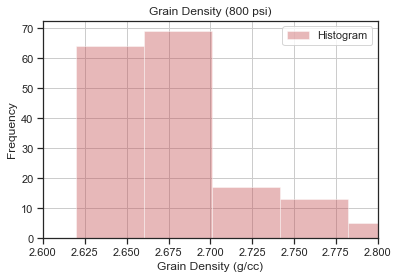

In [17]:
savefn = "Hist_GD_800.png"

# fuction to plot - usage
# plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)

plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (800 psi)", 20, 2.6, 2.8, savefn)

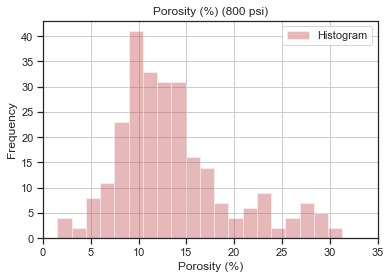

In [18]:
savefn = "Hist_Poro_800.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (800 psi)", 20, 0, 35, savefn)

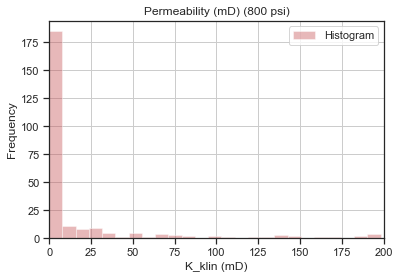

In [19]:
savefn = "Hist_Perm_800.png"
plot_grain_density(df_sub["K_klin (mD)"], "Permeability (mD) (800 psi)", 100, 0, 200, savefn)

#### Plotting the Effect of NOBP

### Only 3 wells have NOBP measurements and that is Kenarong2, Kenarong-3 and Pertang-1

In [20]:
print(mod_df['Well Name'].unique())
print(mod_df['NOB (psi)'].unique())

['Kenarong-2' 'Kenarong-1' 'Kenarong-3' 'Pertang-1' 'Bedong-3' 'Bedong-2'
 'Noring-2']
[ 800. 2698. 1306. 1475. 1546. 1616. 1709. 1701. 2639. 2696. 2522. 2325.
 1852. 1632. 1530. 2225. 3215. 1311. 1450. 1491.  493. 1567. 1600. 1623.
 1995. 2493. 2558. 2642. 2731. 2919. 2983. 2599. 2692. 2759.]


In [21]:
df_sub_A = mod_df[mod_df['Well Name'].str.contains('Kenarong-2')]
print(df_sub_A['NOB (psi)'].unique())

[ 800. 2698. 1306. 1475. 1546. 1616. 1709. 1701. 2639. 2696. 2522. 2325.
 1852. 1632.]


In [22]:
df_sub_B = mod_df[mod_df['Well Name'].str.contains('Kenarong-3')]
print(df_sub_B['NOB (psi)'].unique())

[2225. 3215.  800.]


In [23]:
df_sub_C = mod_df[mod_df['Well Name'].str.contains('Pertang-1')]
print(df_sub_C['NOB (psi)'].unique())

[1311. 1450. 1491.  493. 1567. 1600. 1623. 1995. 2493. 2558. 2642. 2731.
 2919. 2983. 2599. 2692. 2759.]


NOBP = 2500
well = 'Kenarong-2'

df_sub1 = mod_df[(mod_df['Well Name'].str.contains('Kenarong-2'))
                 | (mod_df['Well Name'].str.contains('Kenarong-3'))
                 | (mod_df['Well Name'].str.contains('Pertang-1'))
                 & (mod_df['NOB (psi)'] <= NOBP)]
df_sub2 = mod_df[(mod_df['Well Name'].str.contains('Kenarong-2')) 
                 | (mod_df['Well Name'].str.contains('Kenarong-3')) 
                 | (mod_df['Well Name'].str.contains('Pertang-1')) 
                 & (mod_df['NOB (psi)'] > NOBP)]

print(df_sub1.info())
print(df_sub2.info())

x = df_sub1["Porosity (%)"]
y = df_sub2["Porosity (%)"]

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(121)

sc = ax.scatter(
    x,
    y,
    s = markersize**2,
    alpha=0.5,
    label="Ambient vs Overburden",
    edgecolors = edgecolors,
)

#Add labels
ax.set_xlabel('Ambient Porosity (%)', fontsize=size)
ax.set_ylabel('OB Porosity (%)', fontsize=size)

p = np.polyfit(x, y, 1)
plt.plot(x, p[0]*x + p[1])
f = np.poly1d(p)

#Display Equation
plt.text(16, 10, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))

x1 = df_sub1["K_klin (mD)"]
y1 = df_sub2["K_klin (mD)"]

ax = fig.add_subplot(122)

sc = ax.scatter(
    x1,
    y1,
    s = markersize**2,
    alpha=0.5,
    label="Ambient vs Overburden",
    edgecolors = edgecolors,
)

#Add labels
ax.set_xlabel('Ambient Permeability (mD)', fontsize=size)
ax.set_ylabel('OB Permeability (mD)', fontsize=size)

p = np.polyfit(np.log(x1), np.log(y1), 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(p[0]*np.log(x1) + p[1]) # calculate the fitted values of y 
f = np.poly1d(p)
plt.plot(x1, y_fit, ':')
ax.set_xscale('log')
ax.set_yscale('log')

#Display Equation
plt.text(16, 10, r'Equation ={}'.format(f), fontsize = size,bbox=dict(facecolor='white', alpha=0.25))

plt.tight_layout()

#### Plot cross-plot of Porosity-Permeability

C:\Users\mkumar\Anaconda3\lib\site-packages\matplotlib\collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


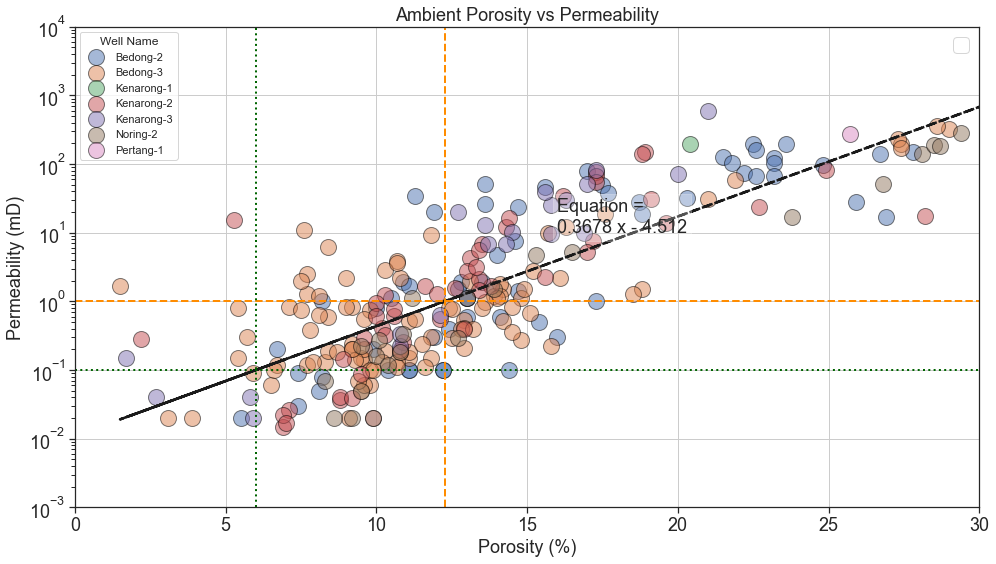

In [24]:
savefn = "Poro_Perm_800.png"

#Cutoff intercept
yint1 = 1
xint1 = 4.512/0.3678

yint2 = 0.1
xint2 = (np.log(0.1)+4.512)/0.3678

plot_PP(mod_df, df_sub, grouped, color, "Ambient Porosity vs Permeability", savefn, xint1, yint1, xint2, yint2)

##### Cross-plot for values not at NOBP of 800 psi

In [25]:
df_sub = mod_df[mod_df['NOB (psi)'] > NOBP]
grouped = df_sub.groupby("Well Name")
color = df_sub['color']

C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


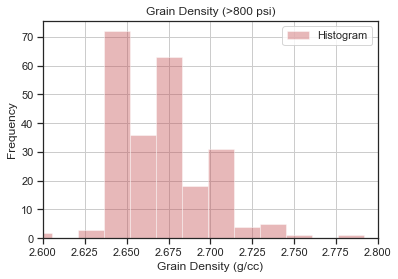

In [26]:
savefn = "Hist_GD_not_800.png"

# fuction to plot - usage
# plot_grain_density (dataframe_column, plot_title, number_bins, x-axis_min, x_axis_max savefile_name)

plot_grain_density(df_sub['Grain Density (g/cc)'], "Grain Density (>800 psi)", 20, 2.6, 2.8, savefn)

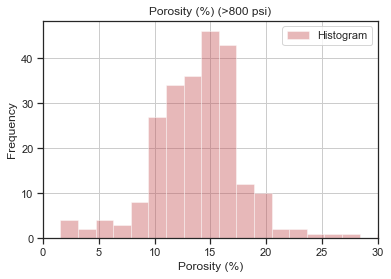

In [27]:
savefn = "Hist_Poro_not_800.png"
plot_grain_density(df_sub["Porosity (%)"], "Porosity (%) (>800 psi)", 20, 0, 30, savefn)

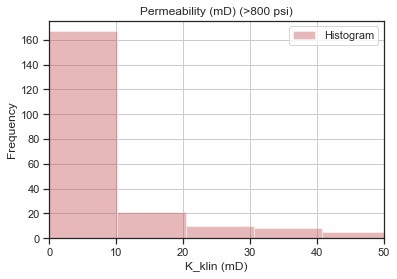

In [28]:
savefn = "Hist_Perm_not_800.png"
plot_grain_density(df_sub["K_klin (mD)"], "Permeability (mD) (>800 psi)", 100, 0, 50, savefn)

C:\Users\mkumar\Anaconda3\lib\site-packages\matplotlib\collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


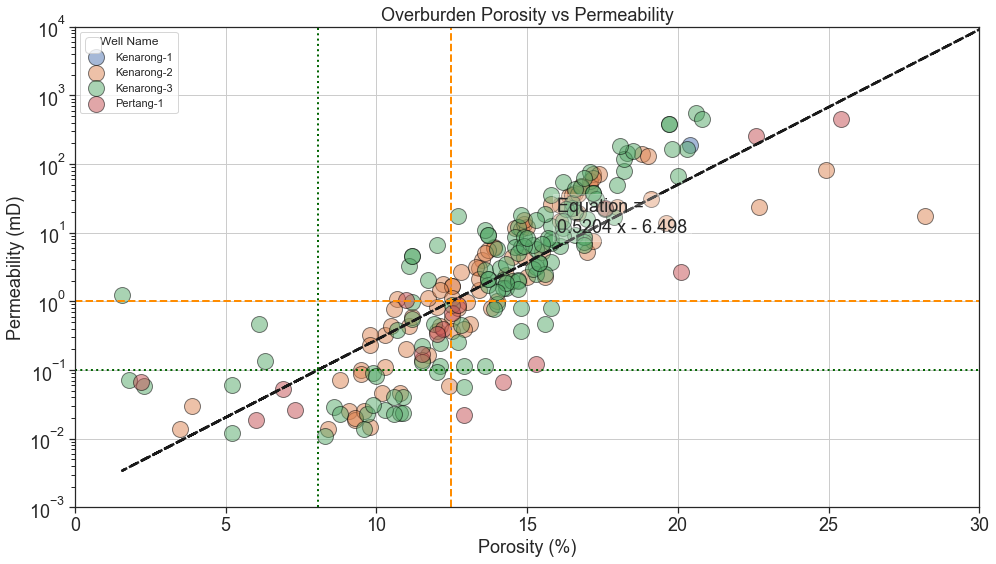

In [29]:
savefn = "Poro_Perm_not_800.png"

#Cutoff intercept
yint1 = 1
xint1 = 6.498/0.5204

yint2 = 0.1
xint2 = (np.log(0.1)+6.498)/0.5204

plot_PP(mod_df, df_sub, grouped, color, "Overburden Porosity vs Permeability", savefn, xint1, yint1, xint2, yint2)